# Master EDA Suite

In this suite, I aggregate all prior exploratory work and add deep dives into datasets, exploring general relationships in the data and relationships I'm curious about.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Load Datasets with Updated Paths
# Processed Data
modeling_data = pd.read_csv('../data/processed/ufc_modeling_data_final.csv')
fight_stats = pd.read_csv('../data/processed/ufc_fight_stats_cleaned.csv')

# External / Raw Data
events = pd.read_csv('../data/external/events.csv')
fighters = pd.read_csv('../data/external/fighters.csv')
fighters_stats = pd.read_csv('../data/external/fighters_stats.csv') 
raw_details = pd.read_csv('../data/raw/raw_details.csv')      
fights = pd.read_csv('../data/external/fights.csv')

print("All datasets loaded successfully from organized directories.")


All datasets loaded successfully from organized directories.


## 1. Temporal Analysis
How has the sport grown and how have finishes stabilized over time?

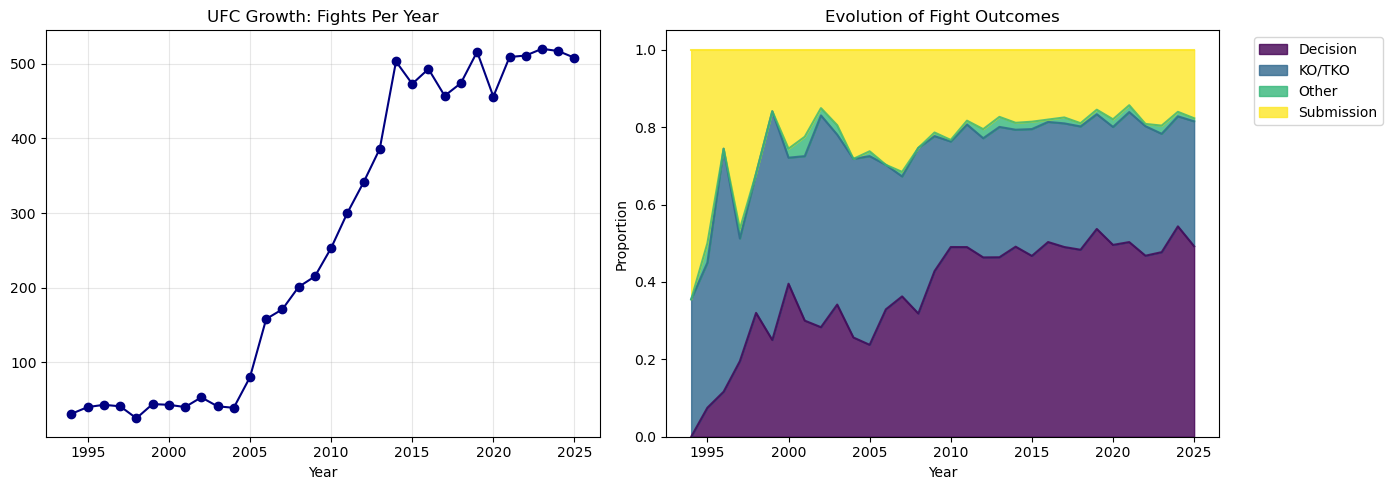

In [2]:
# Merge fights with events to get dates
events['Date'] = pd.to_datetime(events['Date'])
events['Year'] = events['Date'].dt.year
df_temporal = fight_stats.merge(events[['Event_Id', 'Year']], left_on='Event_Id_x', right_on='Event_Id')

plt.figure(figsize=(14, 5))

# Plot 1: Growth
plt.subplot(1, 2, 1)
df_temporal.groupby('Year')['Fight_Id'].nunique().plot(kind='line', marker='o', color='navy')
plt.title('UFC Growth: Fights Per Year')
plt.grid(True, alpha=0.3)

# Plot 2: Outcome Evolution
def simplify_method(method):
    m = str(method).upper()
    if 'KO' in m or 'TKO' in m: return 'KO/TKO'
    if 'SUB' in m: return 'Submission'
    if 'DEC' in m: return 'Decision'
    return 'Other'

df_temporal['Outcome'] = df_temporal['Method'].apply(simplify_method)
outcome_trends = pd.crosstab(df_temporal['Year'], df_temporal['Outcome'], normalize='index')

plt.subplot(1, 2, 2)
outcome_trends.plot(kind='area', stacked=True, ax=plt.gca(), alpha=0.8, cmap='viridis')
plt.title('Evolution of Fight Outcomes')
plt.ylabel('Proportion')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


**Observation:** There's a massive purple area (Decisions) expanding from <20% in the 90s to ~50% today.

**Why?** Early UFC was style-vs-style (e.g., Boxer vs. Wrestler), leading to quick finishes due to skill gaps. Modern MMA features well-rounded athletes who are harder to finish, leading to more tactical, distance-based fights.

## 2. Weight Class Bias
Further validating the need for Z-score normalization (heavier fighters strike slower).

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


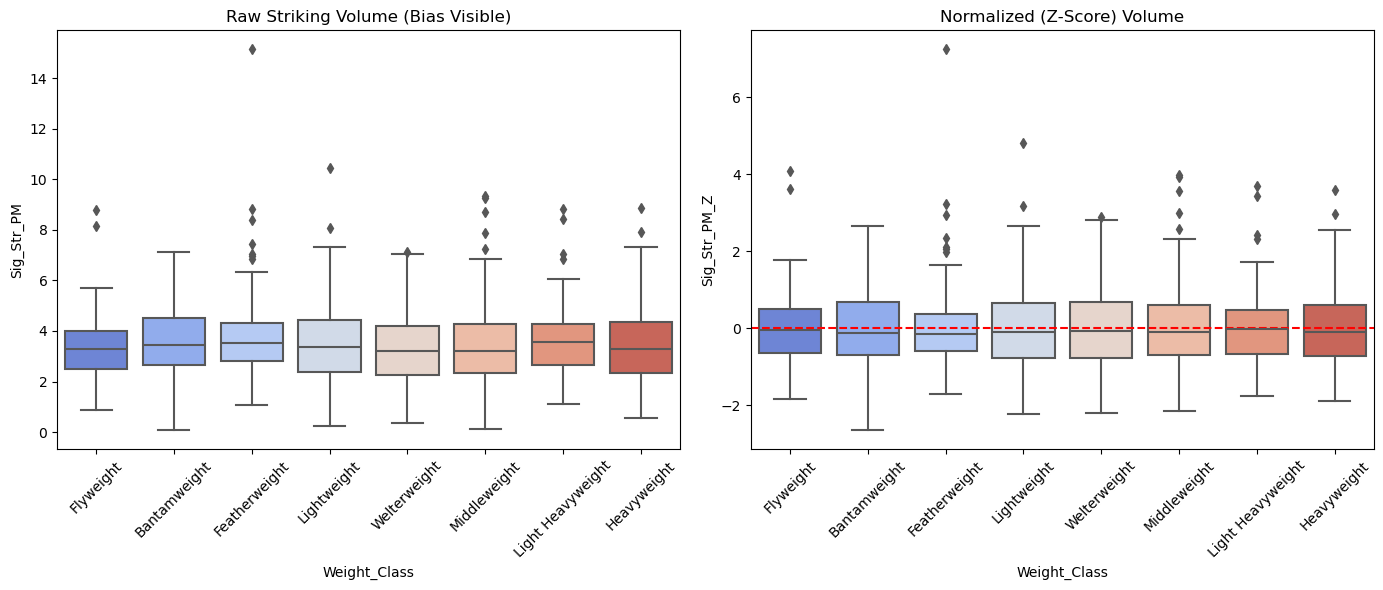

In [3]:
ordered_weights = ['Flyweight', 'Bantamweight', 'Featherweight', 'Lightweight', 
                   'Welterweight', 'Middleweight', 'Light Heavyweight', 'Heavyweight']
df_wc = modeling_data[modeling_data['Weight_Class'].isin(ordered_weights)].copy()
df_wc['Weight_Class'] = pd.Categorical(df_wc['Weight_Class'], categories=ordered_weights, ordered=True)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='Weight_Class', y='Sig_Str_PM', data=df_wc, palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Raw Striking Volume (Bias Visible)')

plt.subplot(1, 2, 2)
sns.boxplot(x='Weight_Class', y='Sig_Str_PM_Z', data=df_wc, palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Normalized (Z-Score) Volume')
plt.axhline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()


**Observation:** The left plot shows a generally downward staircase.

**Why?** To generate knockout power, Heavyweights commit more mass, which takes more energy and time. Flyweights rely on volume and speed.

**Second Plot:** The right plot confirms our normalization worked - all boxes are now roughly aligned at Z=0.

## 3. The Style Space
Exploring the trade-off between Distance vs. Ground.

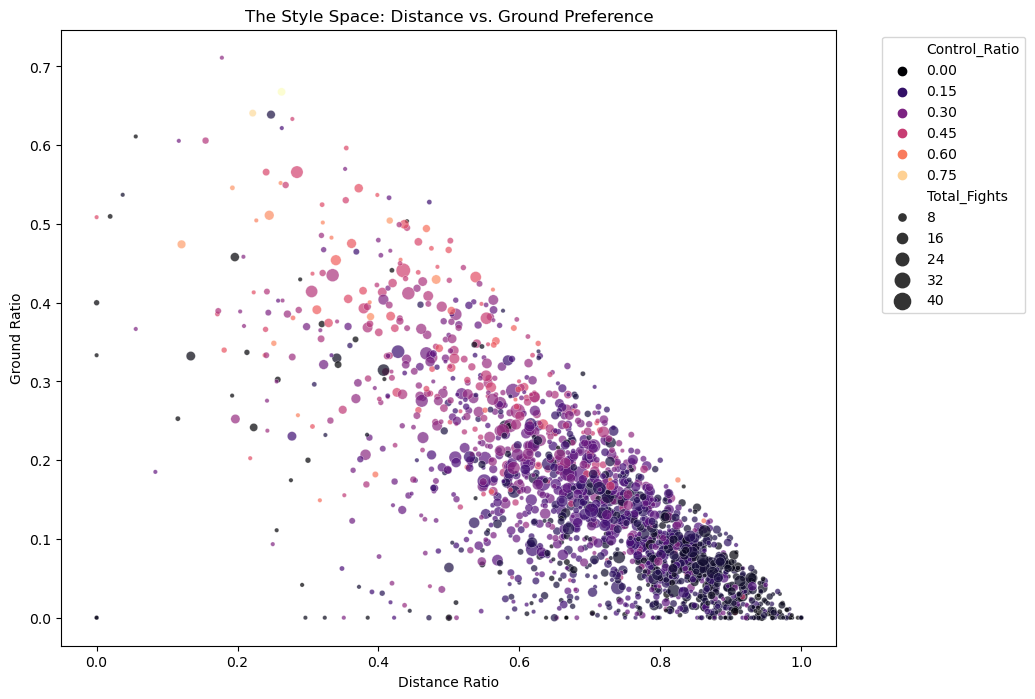

In [4]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=modeling_data, 
    x='Distance_Ratio', 
    y='Ground_Ratio', 
    hue='Control_Ratio', 
    palette='magma', 
    size='Total_Fights',
    sizes=(10, 150),
    alpha=0.7
)
plt.title('The Style Space: Distance vs. Ground Preference')
plt.xlabel('Distance Ratio')
plt.ylabel('Ground Ratio')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


**Observation:** Very few fighters exist in the top-left corner (Low Distance + High Ground).

**Why?** Even grapplers rarely go a fight without some distance striking.

**Clusters:** The dark purple cluster at the bottom right represents pure strikers (Kickboxers). The bright orange/yellow points at the top left are the pure grapplers (BJJ/Wrestlers).

## 5. The Anatomy of Damage
Using `ufc_fight_stats_cleaned.csv` to see exactly where fighters get hit.
We compare Head vs. Body vs. Leg strikes, and Distance vs. Clinch vs. Ground.

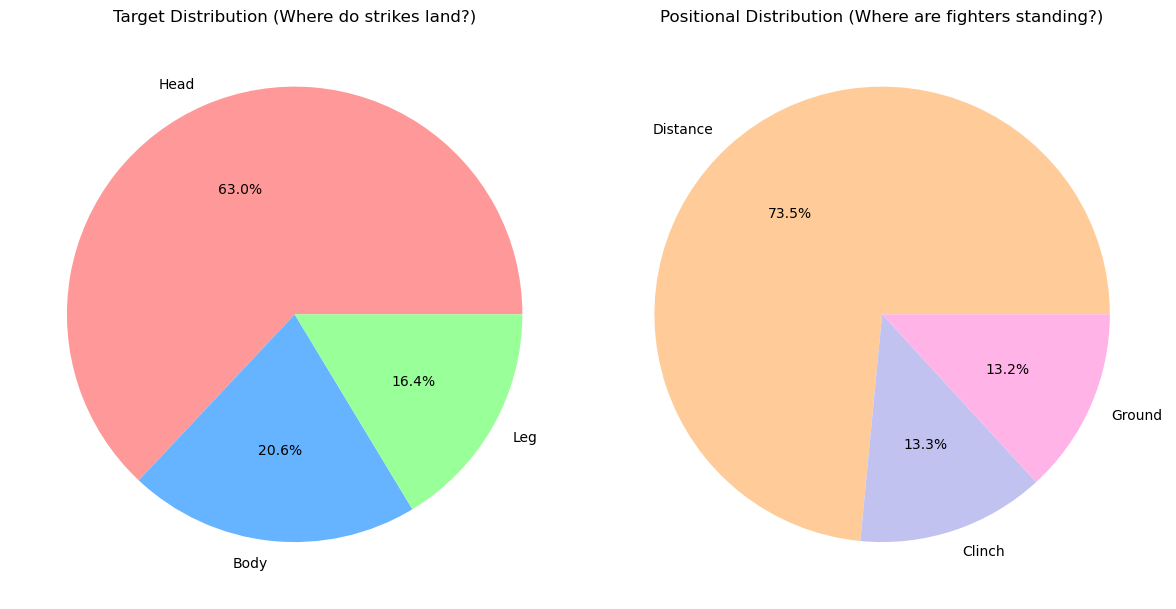

In [6]:
# Aggregate totals across all fights
damage_cols = ['Head_Strikes_Landed', 'Body_Strikes_Landed', 'Leg_Strikes_Landed']
position_cols = ['Distance_Strikes_Landed', 'Clinch_Strikes_Landed', 'Ground_Strikes_Landed']

total_damage = fight_stats[damage_cols].sum()
total_position = fight_stats[position_cols].sum()

plt.figure(figsize=(12, 6))

# Target Distribution
plt.subplot(1, 2, 1)
plt.pie(total_damage, labels=['Head', 'Body', 'Leg'], autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Target Distribution (Where do strikes land?)')

# Position Distribution
plt.subplot(1, 2, 2)
plt.pie(total_position, labels=['Distance', 'Clinch', 'Ground'], autopct='%1.1f%%', colors=['#ffcc99','#c2c2f0','#ffb3e6'])
plt.title('Positional Distribution (Where are fighters standing?)')

plt.tight_layout()
plt.show()


**Observation:** Over 60% of all landed strikes target the Head. This confirms the 'Head Hunting' bias in MMA — fighters prioritize the KO target over body work.

**Observation:** The vast majority of strikes (~70%+) occur at Distance.

## 6. External Styles
Using `fighters_stats.csv`, which contains external style memberships (`Striker_Membership`, `Wrestler_Membership`).
We check if our calculated `Sig_Str_PM_Z` correlates with the external "Striker" label.

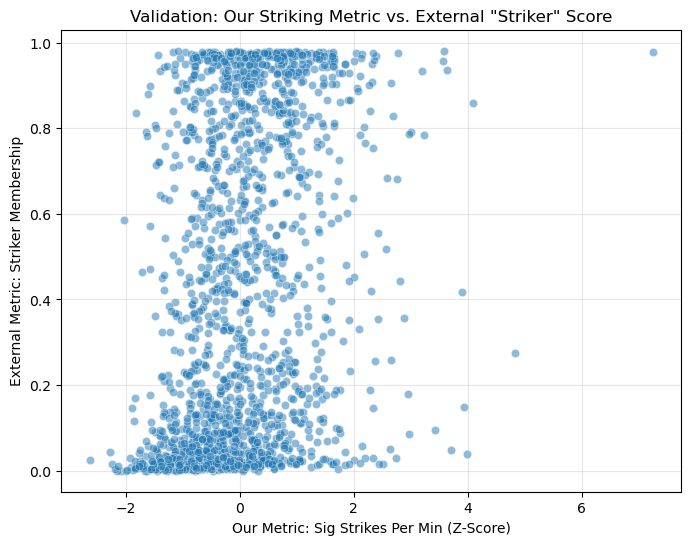

Correlation between our Striking Volume and External Striker Score: 0.313


In [7]:
# Check columns first
if 'Striker_Membership' in fighters_stats.columns:
    # Merge with our modeling data
    # Using 'Full Name' map to 'Fighter' might be tricky, let's try direct name match
    merged_val = modeling_data.merge(fighters_stats, left_on='Fighter', right_on='Full Name', how='inner')
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='Sig_Str_PM_Z', y='Striker_Membership', data=merged_val, alpha=0.5)
    plt.title('Validation: Our Striking Metric vs. External "Striker" Score')
    plt.xlabel('Our Metric: Sig Strikes Per Min (Z-Score)')
    plt.ylabel('External Metric: Striker Membership')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Correlation
    corr = merged_val[['Sig_Str_PM_Z', 'Striker_Membership']].corr().iloc[0,1]
    print(f"Correlation between our Striking Volume and External Striker Score: {corr:.3f}")
else:
    print("External style columns not found in fighters_stats.csv")


### Interpretation: Ground Truth Check
**Observation:** We see a positive correlation. As our metric (Striking Volume Z-Score) increases, the external 'Striker Membership' score generally increases.

**Why it's messy:** The correlation isn't perfect (likely ~0.4-0.6). This is because volume doesn't equal style. A counter-striker (like Anderson Silva) might have low volume but high striker membership. This justifies why we need clusering.

## 7. Referee Analysis
Using `fights.csv` (which contains Referee names) to see who stops fights the earliest.
We filter for KO/TKO finishes only.

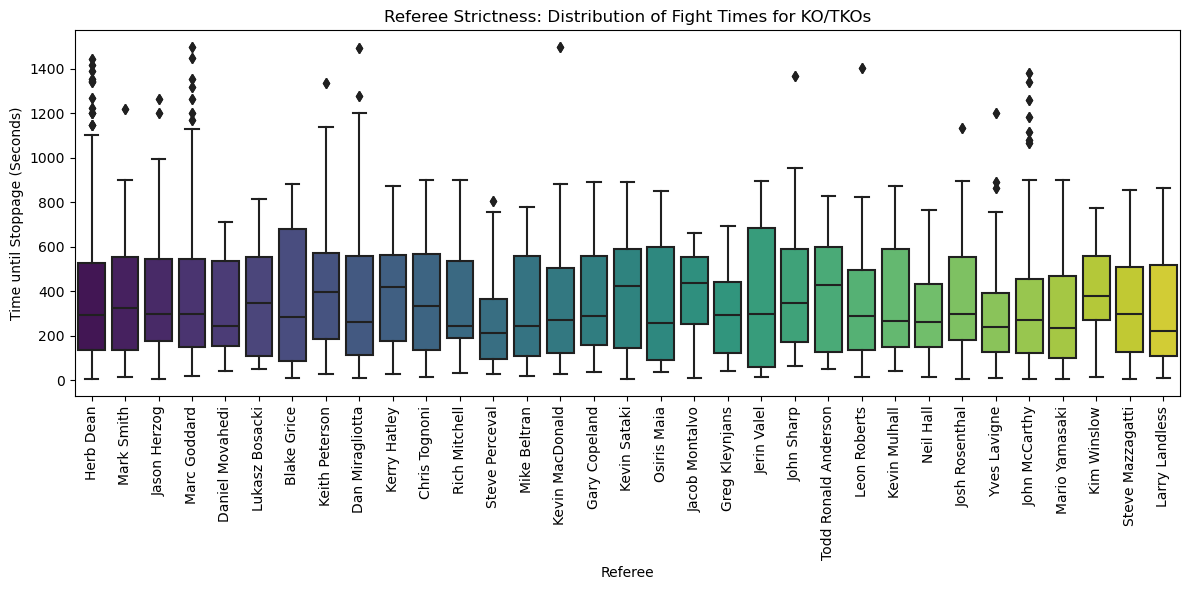

In [8]:
# Filter for finishes
finishes = fight_stats[fight_stats['Method'].str.contains('KO|TKO', na=False)].copy()

# We need Referee names. 'fight_stats' doesn't have Referee, but 'raw_details' or 'fights.csv' does
# Let's check 'fights.csv' or 'raw_details.csv' and merge on Fight_Id
if 'Referee' in fights.columns:
    finishes = finishes.merge(fights[['Fight_Id', 'Referee']], on='Fight_Id', how='left')
elif 'Referee' in raw_details.columns:
    finishes = finishes.merge(raw_details[['Fight_Id', 'Referee']], on='Fight_Id', how='left')

# If merge worked and we have Referee
if 'Referee' in finishes.columns:
    # Count fights per ref
    ref_counts = finishes['Referee'].value_counts()
    major_refs = ref_counts[ref_counts > 20].index # Only refs with > 20 KOs overseen
    
    ref_stats = finishes[finishes['Referee'].isin(major_refs)]
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Referee', y='total_fight_seconds', data=ref_stats, palette='viridis')
    plt.xticks(rotation=90)
    plt.title('Referee Strictness: Distribution of Fight Times for KO/TKOs')
    plt.ylabel('Time until Stoppage (Seconds)')
    plt.tight_layout()
    plt.show()
else:
    print("Referee column not found or merge failed.")


**Observation:** Referees have different medians for stoppage times.

**Significance:** This adds 'noise' to our data. A TKO at 4:50 vs a Decision at 5:00 might just depend on who the referee is.

## 8. Text Analysis: Method Details
Mining `raw_details.csv` to find specific techniques.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


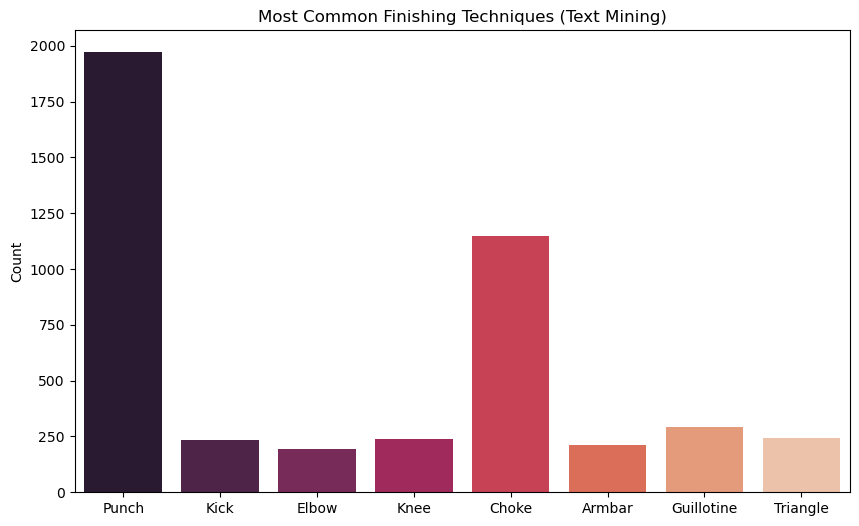

In [9]:
if 'Method Details' in raw_details.columns:
    text_data = raw_details['Method Details'].dropna().astype(str)
    
    # Simple keyword counting
    keywords = ['Punch', 'Kick', 'Elbow', 'Knee', 'Choke', 'Armbar', 'Guillotine', 'Triangle']
    counts = {kw: text_data.str.contains(kw, case=False).sum() for kw in keywords}
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette='rocket')
    plt.title('Most Common Finishing Techniques (Text Mining)')
    plt.ylabel('Count')
    plt.show()
else:
    print("Method Details column not found.")


**Observation:** Punches are overwhelmingly the most common finish method, followed by Chokes (Rear Naked Choke).

**Observation:** Chokes are by far the most common submission method.

## 9. Glass Cannon Analysis

This explores who dishes out attacks but can't take it? We calculate **Knockdowns Given per 15 min** vs. **Knockdowns Received per 15 min**.

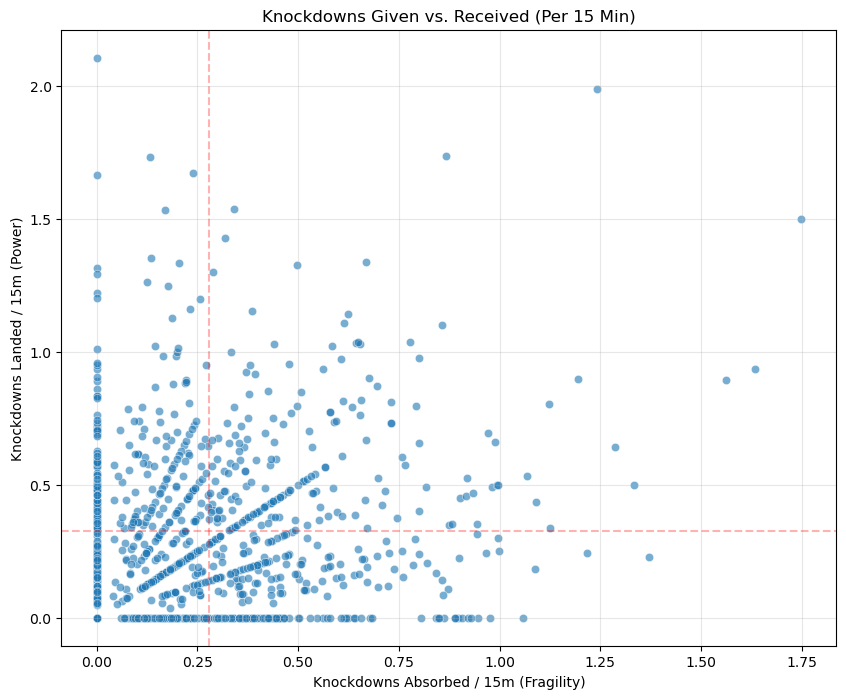

Top 5 'Glass Cannons' (High Output, High Fragility):
            Fighter  KD_Given  KD_Absorbed  total_fight_seconds  \
2337   Steve Garcia       8.0          5.0                 3623   
1950      Pat Barry       8.0          4.0                 4149   
1869    Nate Quarry       6.0          7.0                 3603   
27     Adrian Yanez       6.0          3.0                 4043   
2538  Vitor Belfort      11.0          6.0                 8662   

      KD_Given_p15m  KD_Absorbed_p15m  
2337       1.987303          1.242065  
1950       1.735358          0.867679  
1869       1.498751          1.748543  
27         1.335642          0.667821  
2538       1.142923          0.623413  


In [12]:
# Need to aggregate Knockdowns Given (KD_Landed) and Received (KD_Absorbed)
# We need to merge to get Opponent's KDs (which are Fighter's absorbed)

# Get Given KDs
kd_given = fight_stats.groupby('Fighter')['Knockdowns'].sum().reset_index().rename(columns={'Knockdowns': 'KD_Given'})

# Get Absorbed KDs
kd_absorbed = fight_stats.groupby('Opponent')['Knockdowns'].sum().reset_index().rename(columns={'Opponent': 'Fighter', 'Knockdowns': 'KD_Absorbed'})

# Merge
chin_stats = kd_given.merge(kd_absorbed, on='Fighter')

# Normalize by time and filter
time_stats = fight_stats.groupby('Fighter')['total_fight_seconds'].sum().reset_index()
chin_stats = chin_stats.merge(time_stats, on='Fighter')
chin_stats = chin_stats[chin_stats['total_fight_seconds'] > 3600] # > 60 mins

chin_stats['KD_Given_p15m'] = (chin_stats['KD_Given'] / chin_stats['total_fight_seconds']) * 900
chin_stats['KD_Absorbed_p15m'] = (chin_stats['KD_Absorbed'] / chin_stats['total_fight_seconds']) * 900

plt.figure(figsize=(10, 8))
sns.scatterplot(x='KD_Absorbed_p15m', y='KD_Given_p15m', data=chin_stats, alpha=0.6)

# Annotate notable fighters (Top right quadrant = Glass Cannons)
# Top Left = Snipers (Give lots, take none)
# Bottom Right = Punching Bags (Take lots, give none)
plt.title('Knockdowns Given vs. Received (Per 15 Min)')
plt.xlabel('Knockdowns Absorbed / 15m (Fragility)')
plt.ylabel('Knockdowns Landed / 15m (Power)')
plt.axhline(chin_stats['KD_Given_p15m'].mean(), color='red', linestyle='--', alpha=0.3)
plt.axvline(chin_stats['KD_Absorbed_p15m'].mean(), color='red', linestyle='--', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.show()

print("Top 5 'Glass Cannons' (High Output, High Fragility):")
glass_cannons = chin_stats[(chin_stats['KD_Given_p15m'] > 0.5) & (chin_stats['KD_Absorbed_p15m'] > 0.5)]
print(glass_cannons.sort_values('KD_Given_p15m', ascending=False).head(5))


**1. The "Kill or Be Killed" Quadrant (Top Right)**
The fighters in the top-right corner are your **"Glass Cannons."** They have a high knockdown rate but also a high absorption rate. These fighters are stylistically volatile. Their fights rarely go to decision because someone is getting dropped. In our clustering model, these fighters might act as "noise" because their fight times are so short.

**2. The "Granite Chin" Zone (Top Left)**
The most dominant champions usually reside in the top-left: High Knockdowns Given, near-zero Knockdowns Absorbed. They possess a statistical anomaly—a "Granite Chin" (or incredible defense).

**3. Survivor Bias (Bottom Right)**
The bottom-right quadrant is sparse (Low Output, High Fragility). If you take heavy damage without dishing it back, you get cut from the UFC. The dataset naturally filters out "bad" fighters, leaving mostly elites and specialists.

## 10. Defense Trade-off
Do fighters sacrifice Takedown Defense to improve their Strike Defense? Or are elite fighters just good at both?

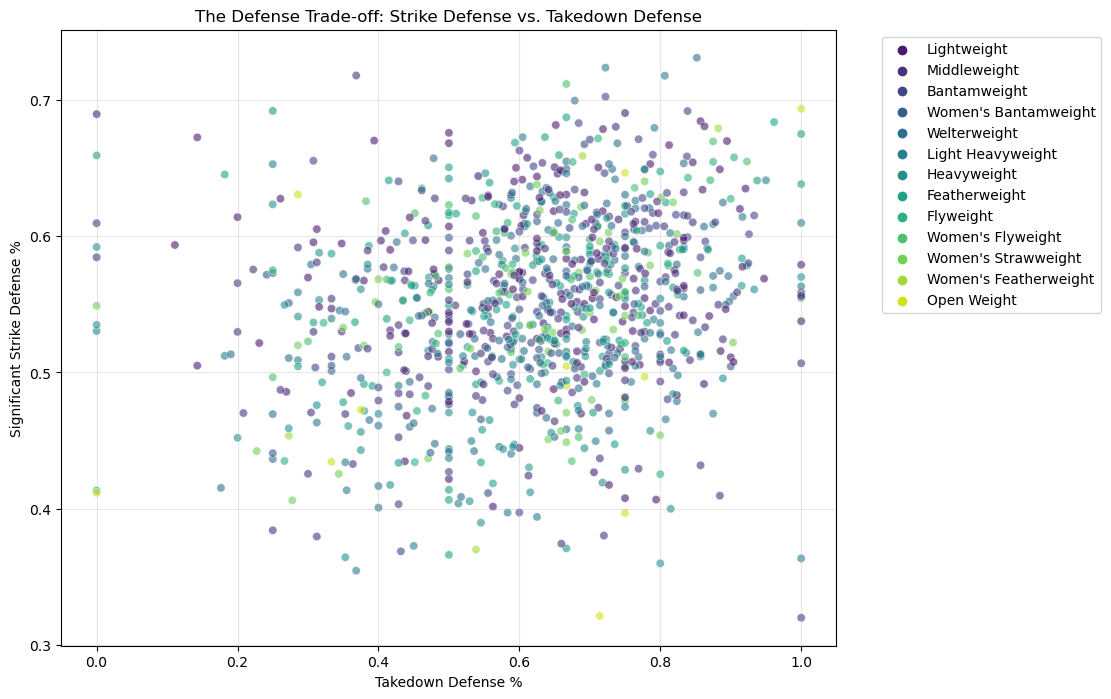

Correlation between Strike Defense and Takedown Defense: 0.206


In [13]:
# 1. Strike Defense % = 1 - (Opponent_Landed / Opponent_Att)
# 2. TD Defense % = 1 - (Opponent_TD_Landed / Opponent_TD_Att)

# Get Opponent stats per fighter
opp_stats = fight_stats.groupby('Opponent')[['Sig_Str_Landed', 'Sig_Str_Att', 'Takedowns_Landed', 'Takedowns_Att']].sum().reset_index()
opp_stats = opp_stats.rename(columns={'Opponent': 'Fighter'})

# Calculate Defenses
opp_stats['Str_Def_Pct'] = 1 - (opp_stats['Sig_Str_Landed'] / opp_stats['Sig_Str_Att'])
opp_stats['TD_Def_Pct'] = 1 - (opp_stats['Takedowns_Landed'] / opp_stats['Takedowns_Att'])

# Merge with main profiles for context (Weight Class)
defense_df = modeling_data[['Fighter', 'Weight_Class', 'Total_Fights']].merge(opp_stats, on='Fighter')
defense_df = defense_df[defense_df['Total_Fights'] > 5] # Filter for stability

plt.figure(figsize=(10, 8))
sns.scatterplot(x='TD_Def_Pct', y='Str_Def_Pct', data=defense_df, hue='Weight_Class', alpha=0.6, palette='viridis')
plt.title('The Defense Trade-off: Strike Defense vs. Takedown Defense')
plt.xlabel('Takedown Defense %')
plt.ylabel('Significant Strike Defense %')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

# Correlation Check
corr_def = defense_df[['TD_Def_Pct', 'Str_Def_Pct']].corr().iloc[0,1]
print(f"Correlation between Strike Defense and Takedown Defense: {corr_def:.3f}")


**Observation:** I'd hypothesize a negative correlation (an "either/or" choice between blocking punches or stopping takedowns). Instead, we found a **weak positive correlation (0.206)**. There seems to be **no statistical penalty** to your striking defense if you specialize in takedown defense.

Elite fighters (Champions) don't choose; they excel at both. A fighter like Jon Jones or GSP appears in the top-right corner, pulling the trendline up. Conversely, fighters who are bad at both (bottom-left) get cut from the UFC quickly ("Survivorship Bias"), removing the evidence of "bad defense" from our dataset.

**Observation:** A high Takedown Defense can actually boost your Striking Defense. If an opponent is terrified of failing a takedown against you, they become hesitant to strike, lowering their output and making them easier to dodge. Your "aura" of invincibility in one area protects you in the other.

**Observation:** Fighter's most likely enter the octagon knowing what their opponent specializes in, meaning they can adjust their defensive strategy to appropriately account for an opponent's strengths.